In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """Basic convolutional block with Conv, BatchNorm, and ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AttentionModule(nn.Module):
    """Spatial and channel attention to focus on important features."""
    def __init__(self, channels):
        super(AttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // 8, 1, bias=False)
        self.fc2 = nn.Conv2d(channels // 8, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        avg_out = self.fc2(self.fc1(avg_out))
        max_out = self.fc2(self.fc1(max_out))
        channel_attn = self.sigmoid(avg_out + max_out)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.conv_spatial(spatial_attn))
        x = x * spatial_attn
        return x

class MultiScaleFeatureExtractor(nn.Module):
    """Extracts features at multiple scales using different kernel sizes."""
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFeatureExtractor, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        self.branch3 = ConvBlock(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.branch5 = ConvBlock(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        )
        self.conv_fuse = ConvBlock(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(x)
        x = torch.cat([b1, b3, b5, bp], dim=1)
        x = self.conv_fuse(x)
        return x

class GlobalContextModule(nn.Module):
    """Captures global dependencies using a transformer-like mechanism."""
    def __init__(self, channels):
        super(GlobalContextModule, self).__init__()
        self.query_conv = nn.Conv2d(channels, channels // 8, 1)
        self.key_conv = nn.Conv2d(channels, channels // 8, 1)
        self.value_conv = nn.Conv2d(channels, channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        query = self.query_conv(x).view(batch, -1, height * width).permute(0, 2, 1)
        key = self.key_conv(x).view(batch, -1, height * width)
        value = self.value_conv(x).view(batch, -1, height * width)
        attention = self.softmax(torch.bmm(query, key))
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        return x + out

class HybridFeatureNet(nn.Module):
    """Modified HybridFeatureNet for CIFAR-10 (32x32 images, 10 classes)."""
    def __init__(self, num_classes=10):
        super(HybridFeatureNet, self).__init__()
        # Adjusted stem for 32x32 images
        self.stem = ConvBlock(3, 32, kernel_size=3, stride=1, padding=1)  # No stride=2
        # We will apply the residual connection before the pooling layer
        self.residual1_proj = ConvBlock(32, 64, kernel_size=1, stride=2) # Projection for first residual
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Downsample to 16x16
        
        # Stage 1 (operates on 16x16)
        self.stage1 = nn.Sequential(
            MultiScaleFeatureExtractor(32, 64),
            AttentionModule(64),
            ConvBlock(64, 64, kernel_size=3, padding=1)
        )
        # The first residual connection is now a projection before pooling
        
        # Stage 2 (operates on 16x16)
        # Need a downsampling step between Stage 1 and Stage 2 to match the increase in channels
        self.downsample1_2 = ConvBlock(64, 128, kernel_size=3, stride=2, padding=1) # Downsample from 16x16 to 8x8
        self.residual2_proj = ConvBlock(64, 128, kernel_size=1, stride=2) # Projection for second residual
        
        self.stage2 = nn.Sequential(
            MultiScaleFeatureExtractor(128, 128), # Input channels should match downsampled output
            AttentionModule(128),
            ConvBlock(128, 128, kernel_size=3, padding=1)
        )
        
        # Stage 3 (operates on 8x8)
        # Need a downsampling step between Stage 2 and Stage 3
        self.downsample2_3 = ConvBlock(128, 256, kernel_size=3, stride=2, padding=1) # Downsample from 8x8 to 4x4
        self.residual3_proj = ConvBlock(128, 256, kernel_size=1, stride=2) # Projection for third residual
        
        self.stage3 = nn.Sequential(
            MultiScaleFeatureExtractor(256, 256), # Input channels should match downsampled output
            GlobalContextModule(256),
            ConvBlock(256, 256, kernel_size=3, padding=1)
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        self._initialize_weights()

    def forward(self, x):
        # Stem
        x = self.stem(x) # Output: Batch x 32 x 32 x 32
        
        # First residual connection (applied to pre-pooled features)
        residual1 = self.residual1_proj(x) # Output: Batch x 64 x 16 x 16
        
        # Pooling
        x = self.pool(x) # Output: Batch x 32 x 16 x 16
        
        # Stage 1
        x = self.stage1(x) # Input: Batch x 32 x 16 x 16, Output: Batch x 64 x 16 x 16
        
        # Add first residual connection
        x = x + residual1 # Output: Batch x 64 x 16 x 16
        
        # Downsample and apply second residual connection
        residual2 = self.residual2_proj(x) # Input: Batch x 64 x 16 x 16, Output: Batch x 128 x 8 x 8
        x = self.downsample1_2(x) # Input: Batch x 64 x 16 x 16, Output: Batch x 128 x 8 x 8
        
        # Stage 2
        x = self.stage2(x) # Input: Batch x 128 x 8 x 8, Output: Batch x 128 x 8 x 8
        
        # Add second residual connection
        x = x + residual2 # Output: Batch x 128 x 8 x 8
        
        # Downsample and apply third residual connection
        residual3 = self.residual3_proj(x) # Input: Batch x 128 x 8 x 8, Output: Batch x 256 x 4 x 4
        x = self.downsample2_3(x) # Input: Batch x 128 x 8 x 8, Output: Batch x 256 x 4 x 4
        
        # Stage 3
        x = self.stage3(x) # Input: Batch x 256 x 4 x 4, Output: Batch x 256 x 4 x 4
        
        # Add third residual connection
        x = x + residual3 # Output: Batch x 256 x 4 x 4
        
        # Global pooling and FC
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# SimpleCNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(128 * 4 * 4, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Evaluation function
def evaluate(model, testloader, criterion, device, class_names):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (predicted[i] == labels[i]).item()
                class_total[label] += 1
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    class_acc = [100. * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_names))]
    return test_loss, test_acc, class_acc, all_preds, all_labels

# Data loading
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize models and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hfn_model = HybridFeatureNet(num_classes=10).to(device)
hfn_model.load_state_dict(torch.load('hfn_cifar10.pth', map_location=device))
cnn_model = SimpleCNN(num_classes=10).to(device)
cnn_model.load_state_dict(torch.load('cnn_cifar10.pth', map_location=device))

criterion = nn.CrossEntropyLoss()

# Evaluate models
print("Evaluating HFN...")
hfn_loss, hfn_acc, hfn_class_acc, hfn_preds, hfn_labels = evaluate(hfn_model, testloader, criterion, device, class_names)
print(f"HFN Test Loss: {hfn_loss:.4f}, Test Accuracy: {hfn_acc:.2f}%")
print("HFN Per-class Accuracy:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {hfn_class_acc[i]:.2f}%")

print("\nEvaluating SimpleCNN...")
cnn_loss, cnn_acc, cnn_class_acc, cnn_preds, cnn_labels = evaluate(cnn_model, testloader, criterion, device, class_names)
print(f"SimpleCNN Test Loss: {cnn_loss:.4f}, Test Accuracy: {cnn_acc:.2f}%")
print("SimpleCNN Per-class Accuracy:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {cnn_class_acc[i]:.2f}%")

# Confusion matrix
hfn_cm = confusion_matrix(hfn_labels, hfn_preds)
cnn_cm = confusion_matrix(cnn_labels, cnn_preds)
print("\nHFN Confusion Matrix:\n", hfn_cm)
print("\nSimpleCNN Confusion Matrix:\n", cnn_cm)

Evaluating HFN...
HFN Test Loss: 0.4393, Test Accuracy: 84.92%
HFN Per-class Accuracy:
airplane: 89.80%
automobile: 93.60%
bird: 78.80%
cat: 64.30%
deer: 85.00%
dog: 76.90%
frog: 90.30%
horse: 88.30%
ship: 91.40%
truck: 90.80%

Evaluating SimpleCNN...
SimpleCNN Test Loss: 0.8952, Test Accuracy: 68.21%
SimpleCNN Per-class Accuracy:
airplane: 72.80%
automobile: 76.10%
bird: 48.40%
cat: 46.10%
deer: 64.50%
dog: 58.60%
frog: 79.40%
horse: 72.40%
ship: 81.40%
truck: 82.40%

HFN Confusion Matrix:
 [[898   8  26  10   4   1   5   4  25  19]
 [  9 936   1   1   0   0   3   0   9  41]
 [ 50   2 788  22  45  30  39  16   3   5]
 [ 19   7  49 643  47 133  56  25  10  11]
 [ 14   2  40  18 850  22  27  23   4   0]
 [ 10   3  24 104  34 769  15  36   2   3]
 [  7   1  35  23  12  13 903   4   1   1]
 [ 20   1  15  22  29  20   3 883   1   6]
 [ 46   6   5   5   3   0   3   4 914  14]
 [ 18  41   2   8   0   2   2   4  15 908]]

SimpleCNN Confusion Matrix:
 [[728  10  72  32  18   2   9  16  75  38]

**HFN Architecture**

* HFN Architecture with ASCR Layer

Epoch 1/100 | Train Loss: 1.6150 | Test Loss: 1.4367 | Train Acc: 40.06% | Test Acc: 47.84%
Epoch 2/100 | Train Loss: 1.2599 | Test Loss: 1.0870 | Train Acc: 54.49% | Test Acc: 61.52%
Epoch 3/100 | Train Loss: 1.1147 | Test Loss: 1.0711 | Train Acc: 60.04% | Test Acc: 62.05%
Epoch 4/100 | Train Loss: 1.0233 | Test Loss: 0.8819 | Train Acc: 63.41% | Test Acc: 69.05%
Epoch 5/100 | Train Loss: 0.9385 | Test Loss: 0.8173 | Train Acc: 66.82% | Test Acc: 71.72%
Epoch 6/100 | Train Loss: 0.8707 | Test Loss: 0.8937 | Train Acc: 69.22% | Test Acc: 69.22%
Epoch 7/100 | Train Loss: 0.8236 | Test Loss: 0.6686 | Train Acc: 71.01% | Test Acc: 76.30%
Epoch 8/100 | Train Loss: 0.7748 | Test Loss: 0.6441 | Train Acc: 72.82% | Test Acc: 77.61%
Epoch 9/100 | Train Loss: 0.7414 | Test Loss: 0.6573 | Train Acc: 74.02% | Test Acc: 77.12%
Epoch 10/100 | Train Loss: 0.7206 | Test Loss: 0.6321 | Train Acc: 74.78% | Test Acc: 77.75%
Epoch 11/100 | Train Loss: 0.6890 | Test Loss: 0.6430 | Train Acc: 76.08% | Tes

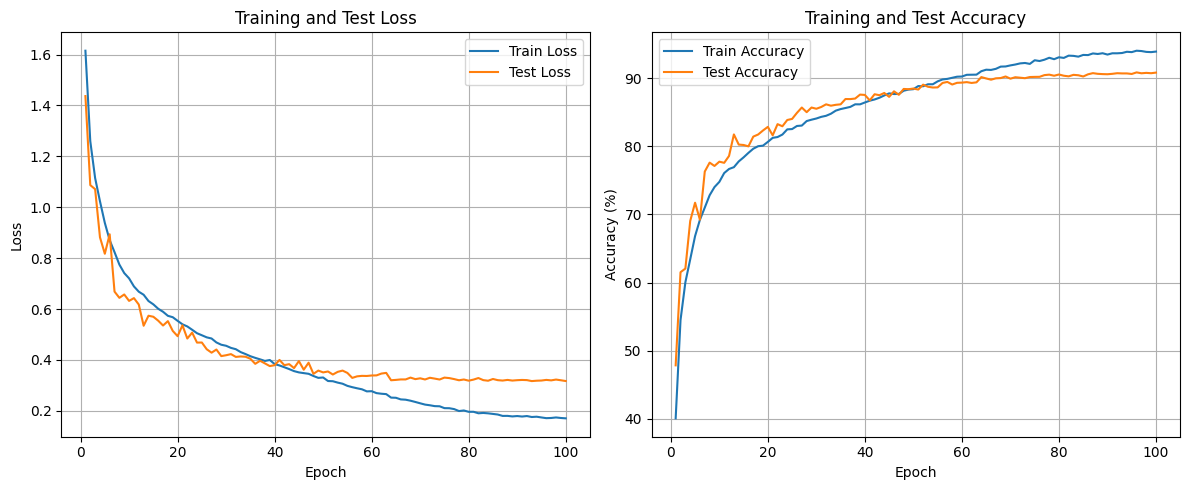

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Architecture Definition ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AttentionModule(nn.Module):
    def __init__(self, channels):
        super(AttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // 8, 1, bias=False)
        self.fc2 = nn.Conv2d(channels // 8, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        avg_out = self.fc2(self.fc1(self.avg_pool(x)))
        max_out = self.fc2(self.fc1(self.max_pool(x)))
        channel_attn = self.sigmoid(avg_out + max_out)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.conv_spatial(spatial_attn))
        x = x * spatial_attn
        return x

class ASCRLayer(nn.Module):
    def __init__(self, channels, reduction_ratio=8, temp_init=1.0):
        super(ASCRLayer, self).__init__()
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.channel_fc1 = nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False)
        self.channel_fc2 = nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.temperature = nn.Parameter(torch.tensor(temp_init))
        self.sigmoid = nn.Sigmoid()
        self.suppression_prob = 0.2

    def forward(self, x, training=True):
        batch, channels, height, width = x.size()
        avg_pool = self.channel_avg_pool(x)
        max_pool = self.channel_max_pool(x)
        channel_attn = self.channel_fc1(avg_pool)
        channel_attn = F.relu(channel_attn)
        channel_attn = self.channel_fc2(channel_attn)
        channel_attn = max_pool + channel_attn
        channel_attn = self.sigmoid(channel_attn / self.temperature)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.spatial_conv(spatial_attn) / self.temperature)
        x = x * spatial_attn
        if training:
            suppression_mask = torch.ones_like(x)
            low_weight_mask = (channel_attn < 0.3).float() * (spatial_attn < 0.3).float()
            rand_mask = torch.rand_like(low_weight_mask) < self.suppression_prob
            suppression_mask[low_weight_mask * rand_mask == 1] = 0.5
            x = x * suppression_mask
        return x

class MultiScaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFeatureExtractor, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        self.branch3 = ConvBlock(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.branch5 = ConvBlock(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        )
        self.conv_fuse = ConvBlock(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(x)
        x = torch.cat([b1, b3, b5, bp], dim=1)
        x = self.conv_fuse(x)
        return x

class GlobalContextModule(nn.Module):
    def __init__(self, channels):
        super(GlobalContextModule, self).__init__()
        self.query_conv = nn.Conv2d(channels, channels // 8, 1)
        self.key_conv = nn.Conv2d(channels, channels // 8, 1)
        self.value_conv = nn.Conv2d(channels, channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        query = self.query_conv(x).view(batch, -1, height * width).permute(0, 2, 1)
        key = self.key_conv(x).view(batch, -1, height * width)
        value = self.value_conv(x).view(batch, -1, height * width)
        attention = self.softmax(torch.bmm(query, key))
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        return x + out

class HybridFeatureNet(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridFeatureNet, self).__init__()
        self.stem = ConvBlock(3, 32, kernel_size=3, stride=1, padding=1)
        self.residual1_proj = ConvBlock(32, 64, kernel_size=1, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.stage1 = nn.Sequential(
            MultiScaleFeatureExtractor(32, 64),
            AttentionModule(64),
            ConvBlock(64, 64, kernel_size=3, padding=1)
        )
        self.downsample1_2 = ConvBlock(64, 128, kernel_size=3, stride=2, padding=1)
        self.residual2_proj = ConvBlock(64, 128, kernel_size=1, stride=2)
        self.stage2 = nn.Sequential(
            MultiScaleFeatureExtractor(128, 128),
            AttentionModule(128),
            ASCRLayer(128),
            nn.Dropout(0.3),  # Increased from 0.2 to reduce overfitting
            ConvBlock(128, 128, kernel_size=3, padding=1)
        )
        self.downsample2_3 = ConvBlock(128, 256, kernel_size=3, stride=2, padding=1)
        self.residual3_proj = ConvBlock(128, 256, kernel_size=1, stride=2)
        self.stage3 = nn.Sequential(
            MultiScaleFeatureExtractor(256, 256),
            GlobalContextModule(256),
            ConvBlock(256, 256, kernel_size=3, padding=1)
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.stem(x)
        residual1 = self.residual1_proj(x)
        x = self.pool(x)
        x = self.stage1(x)
        x = x + residual1
        residual2 = self.residual2_proj(x)
        x = self.downsample1_2(x)
        x = self.stage2(x)
        x = x + residual2
        residual3 = self.residual3_proj(x)
        x = self.downsample2_3(x)
        x = self.stage3(x)
        x = x + residual3
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# --- Data Loading with Enhanced Augmentation ---
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))  # Added Cutout
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# --- Training Setup ---
model = HybridFeatureNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)  # Increased weight decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # Smoother LR decay

# Lists to store metrics for visualization
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_list = []

# --- Training Loop with Early Stopping ---
num_epochs = 100
best_test_loss = float('inf')
patience = 15
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / train_total

    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            test_total += target.size(0)
            test_correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / test_total

    # Store metrics
    epochs_list.append(epoch + 1)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        torch.save(best_model_state, 'best_hybrid_feature_net.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            torch.save(best_model_state, 'best_hybrid_feature_net.pth')
            break

    scheduler.step()

# --- Final Evaluation ---
model.eval()
test_loss, test_correct, test_total = 0, 0, 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        _, predicted = output.max(1)
        test_total += target.size(0)
        test_correct += predicted.eq(target).sum().item()

test_loss /= len(test_loader)
test_acc = 100. * test_correct / test_total
print(f"Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.2f}%")

torch.save(best_model_state, 'best_hybrid_feature_net.pth')

# --- Plotting Training and Test Metrics ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', color='#1f77b4')
plt.plot(epochs_list, test_losses, label='Test Loss', color='#ff7f0e')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label='Train Accuracy', color='#1f77b4')
plt.plot(epochs_list, test_accuracies, label='Test Accuracy', color='#ff7f0e')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Inference**

In [14]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define the model architecture (must match the trained model)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AttentionModule(nn.Module):
    def __init__(self, channels):
        super(AttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // 8, 1, bias=False)
        self.fc2 = nn.Conv2d(channels // 8, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        avg_out = self.fc2(self.fc1(self.avg_pool(x)))
        max_out = self.fc2(self.fc1(self.max_pool(x)))
        channel_attn = self.sigmoid(avg_out + max_out)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.conv_spatial(spatial_attn))
        x = x * spatial_attn
        return x

class ASCRLayer(nn.Module):
    def __init__(self, channels, reduction_ratio=8, temp_init=1.0):
        super(ASCRLayer, self).__init__()
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.channel_fc1 = nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False)
        self.channel_fc2 = nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.temperature = nn.Parameter(torch.tensor(temp_init))
        self.sigmoid = nn.Sigmoid()
        self.suppression_prob = 0.2

    def forward(self, x, training=True):
        batch, channels, height, width = x.size()
        avg_pool = self.channel_avg_pool(x)
        max_pool = self.channel_max_pool(x)
        channel_attn = self.channel_fc1(avg_pool)
        channel_attn = F.relu(channel_attn)
        channel_attn = self.channel_fc2(channel_attn)
        channel_attn = max_pool + channel_attn
        channel_attn = self.sigmoid(channel_attn / self.temperature)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.spatial_conv(spatial_attn) / self.temperature)
        x = x * spatial_attn
        if training:
            suppression_mask = torch.ones_like(x)
            low_weight_mask = (channel_attn < 0.3).float() * (spatial_attn < 0.3).float()
            rand_mask = torch.rand_like(low_weight_mask) < self.suppression_prob
            suppression_mask[low_weight_mask * rand_mask == 1] = 0.5
            x = x * suppression_mask
        return x

class MultiScaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFeatureExtractor, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        self.branch3 = ConvBlock(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.branch5 = ConvBlock(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        )
        self.conv_fuse = ConvBlock(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(x)
        x = torch.cat([b1, b3, b5, bp], dim=1)
        x = self.conv_fuse(x)
        return x

class GlobalContextModule(nn.Module):
    def __init__(self, channels):
        super(GlobalContextModule, self).__init__()
        self.query_conv = nn.Conv2d(channels, channels // 8, 1)
        self.key_conv = nn.Conv2d(channels, channels // 8, 1)
        self.value_conv = nn.Conv2d(channels, channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        query = self.query_conv(x).view(batch, -1, height * width).permute(0, 2, 1)
        key = self.key_conv(x).view(batch, -1, height * width)
        value = self.value_conv(x).view(batch, -1, height * width)
        attention = self.softmax(torch.bmm(query, key))
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        return x + out

class HybridFeatureNet(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridFeatureNet, self).__init__()
        self.stem = ConvBlock(3, 32, kernel_size=3, stride=1, padding=1)
        self.residual1_proj = ConvBlock(32, 64, kernel_size=1, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.stage1 = nn.Sequential(
            MultiScaleFeatureExtractor(32, 64),
            AttentionModule(64),
            ConvBlock(64, 64, kernel_size=3, padding=1)
        )
        self.downsample1_2 = ConvBlock(64, 128, kernel_size=3, stride=2, padding=1)
        self.residual2_proj = ConvBlock(64, 128, kernel_size=1, stride=2)
        self.stage2 = nn.Sequential(
            MultiScaleFeatureExtractor(128, 128),
            AttentionModule(128),
            ASCRLayer(128),
            nn.Dropout(0.3),
            ConvBlock(128, 128, kernel_size=3, padding=1)
        )
        self.downsample2_3 = ConvBlock(128, 256, kernel_size=3, stride=2, padding=1)
        self.residual3_proj = ConvBlock(128, 256, kernel_size=1, stride=2)
        self.stage3 = nn.Sequential(
            MultiScaleFeatureExtractor(256, 256),
            GlobalContextModule(256),
            ConvBlock(256, 256, kernel_size=3, padding=1)
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.stem(x)
        residual1 = self.residual1_proj(x)
        x = self.pool(x)
        x = self.stage1(x)
        x = x + residual1
        residual2 = self.residual2_proj(x)
        x = self.downsample1_2(x)
        x = self.stage2(x)
        x = x + residual2
        residual3 = self.residual3_proj(x)
        x = self.downsample2_3(x)
        x = self.stage3(x)
        x = x + residual3
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Define the preprocessing pipeline (same as test transform in training)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to CIFAR-10 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the saved model
model = HybridFeatureNet(num_classes=10).to(device)
model.load_state_dict(torch.load('best_hybrid_feature_net.pth', map_location=device))
model.eval()  # Set to evaluation mode

# Function to test a single image
def test_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
        predicted_class = classes[predicted.item()]
        probabilities = torch.softmax(output, dim=1)[0] * 100  # Convert to percentages

    # Print results
    print(f"Predicted class: {predicted_class}")
    print("Class probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{classes[i]}: {prob.item():.2f}%")

# Path to your unseen image
image_path = 'Test_img10.webp'  # Replace with the actual path to your image

# Test the image
test_image(image_path)

Predicted class: truck
Class probabilities:
airplane: 0.00%
automobile: 0.01%
bird: 0.00%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.00%
ship: 0.00%
truck: 99.99%


**Inference with confusion matrix with prediction graph**

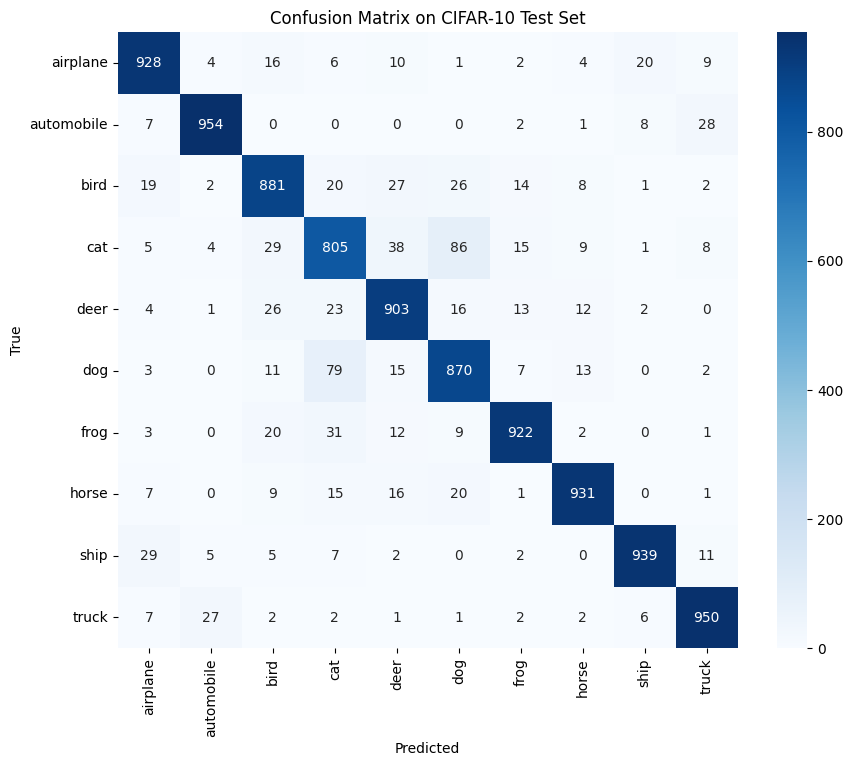

Predicted class: cat
Class probabilities:
airplane: 0.00%
automobile: 0.00%
bird: 0.00%
cat: 100.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.00%
ship: 0.00%
truck: 0.00%


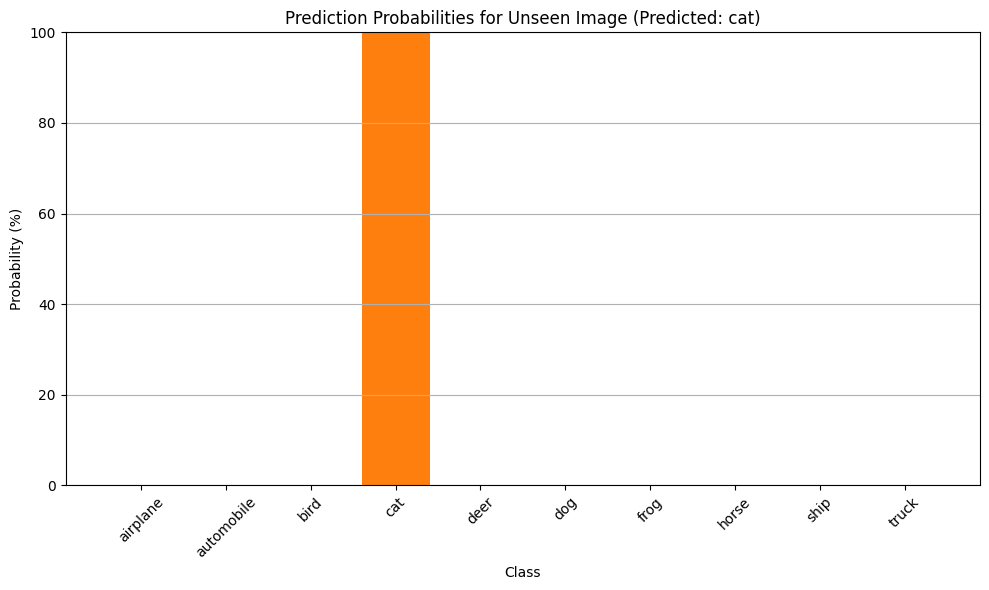

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define the model architecture (same as before)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AttentionModule(nn.Module):
    def __init__(self, channels):
        super(AttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // 8, 1, bias=False)
        self.fc2 = nn.Conv2d(channels // 8, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        avg_out = self.fc2(self.fc1(self.avg_pool(x)))
        max_out = self.fc2(self.fc1(self.max_pool(x)))
        channel_attn = self.sigmoid(avg_out + max_out)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.conv_spatial(spatial_attn))
        x = x * spatial_attn
        return x

class ASCRLayer(nn.Module):
    def __init__(self, channels, reduction_ratio=8, temp_init=1.0):
        super(ASCRLayer, self).__init__()
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.channel_fc1 = nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False)
        self.channel_fc2 = nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.temperature = nn.Parameter(torch.tensor(temp_init))
        self.sigmoid = nn.Sigmoid()
        self.suppression_prob = 0.2

    def forward(self, x, training=True):
        batch, channels, height, width = x.size()
        avg_pool = self.channel_avg_pool(x)
        max_pool = self.channel_max_pool(x)
        channel_attn = self.channel_fc1(avg_pool)
        channel_attn = F.relu(channel_attn)
        channel_attn = self.channel_fc2(channel_attn)
        channel_attn = max_pool + channel_attn
        channel_attn = self.sigmoid(channel_attn / self.temperature)
        x = x * channel_attn
        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_attn = self.sigmoid(self.spatial_conv(spatial_attn) / self.temperature)
        x = x * spatial_attn
        if training:
            suppression_mask = torch.ones_like(x)
            low_weight_mask = (channel_attn < 0.3).float() * (spatial_attn < 0.3).float()
            rand_mask = torch.rand_like(low_weight_mask) < self.suppression_prob
            suppression_mask[low_weight_mask * rand_mask == 1] = 0.5
            x = x * suppression_mask
        return x

class MultiScaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFeatureExtractor, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        self.branch3 = ConvBlock(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.branch5 = ConvBlock(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels // 4, kernel_size=1)
        )
        self.conv_fuse = ConvBlock(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(x)
        x = torch.cat([b1, b3, b5, bp], dim=1)
        x = self.conv_fuse(x)
        return x

class GlobalContextModule(nn.Module):
    def __init__(self, channels):
        super(GlobalContextModule, self).__init__()
        self.query_conv = nn.Conv2d(channels, channels // 8, 1)
        self.key_conv = nn.Conv2d(channels, channels // 8, 1)
        self.value_conv = nn.Conv2d(channels, channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        query = self.query_conv(x).view(batch, -1, height * width).permute(0, 2, 1)
        key = self.key_conv(x).view(batch, -1, height * width)
        value = self.value_conv(x).view(batch, -1, height * width)
        attention = self.softmax(torch.bmm(query, key))
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        return x + out

class HybridFeatureNet(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridFeatureNet, self).__init__()
        self.stem = ConvBlock(3, 32, kernel_size=3, stride=1, padding=1)
        self.residual1_proj = ConvBlock(32, 64, kernel_size=1, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.stage1 = nn.Sequential(
            MultiScaleFeatureExtractor(32, 64),
            AttentionModule(64),
            ConvBlock(64, 64, kernel_size=3, padding=1)
        )
        self.downsample1_2 = ConvBlock(64, 128, kernel_size=3, stride=2, padding=1)
        self.residual2_proj = ConvBlock(64, 128, kernel_size=1, stride=2)
        self.stage2 = nn.Sequential(
            MultiScaleFeatureExtractor(128, 128),
            AttentionModule(128),
            ASCRLayer(128),
            nn.Dropout(0.3),
            ConvBlock(128, 128, kernel_size=3, padding=1)
        )
        self.downsample2_3 = ConvBlock(128, 256, kernel_size=3, stride=2, padding=1)
        self.residual3_proj = ConvBlock(128, 256, kernel_size=1, stride=2)
        self.stage3 = nn.Sequential(
            MultiScaleFeatureExtractor(256, 256),
            GlobalContextModule(256),
            ConvBlock(256, 256, kernel_size=3, padding=1)
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.stem(x)
        residual1 = self.residual1_proj(x)
        x = self.pool(x)
        x = self.stage1(x)
        x = x + residual1
        residual2 = self.residual2_proj(x)
        x = self.downsample1_2(x)
        x = self.stage2(x)
        x = x + residual2
        residual3 = self.residual3_proj(x)
        x = self.downsample2_3(x)
        x = self.stage3(x)
        x = x + residual3
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Load the saved model
model = HybridFeatureNet(num_classes=10).to(device)
try:
    model.load_state_dict(torch.load('best_hybrid_feature_net.pth', map_location=device))
    model.eval()
except FileNotFoundError:
    print("Error: Model file 'best_hybrid_feature_net.pth' not found. Please ensure the file exists.")
    exit()

#CIFAR-10 test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Compute confusion matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on CIFAR-10 Test Set')
plt.show()

def test_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image file '{image_path}' not found. Please provide a valid image path.")
        return None, None
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None

    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)[0].cpu().numpy() * 100
        predicted_idx = np.argmax(probabilities)
        predicted_class = classes[predicted_idx]

    print(f"Predicted class: {predicted_class}")
    print("Class probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{classes[i]}: {prob:.2f}%")

    plt.figure(figsize=(10, 6))
    colors = ['#1f77b4' if i != predicted_idx else '#ff7f0e' for i in range(len(classes))]
    plt.bar(classes, probabilities, color=colors)
    plt.xlabel('Class')
    plt.ylabel('Probability (%)')
    plt.title(f'Prediction Probabilities for Unseen Image (Predicted: {predicted_class})')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    return predicted_class, probabilities

image_path = 'Img\Test_img4.webp'  

# Test the image and display results
predicted_class, probabilities = test_image(image_path)
if predicted_class is None:
    print("Exiting due to image loading error.")
    exit()